<center><h1>Sentiment Analysis using Transformers by HuggingFace Pytorch</h1></center>
<br>
<center>Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.</center>
<br>
<center><img height=200 width=200 src = https://pytorch.org/assets/images/huggingface-logo.png></center>

<br>
<center><h4>I will be using the HuggingFace Python package for predicting question tags for this StackOverflow dataset. I'm just a beginner with this so please feel free to comment if I can do something better.</h4></center>

<br>
<center><img src = https://www.codemotion.com/magazine/wp-content/uploads/2020/05/bert-google-896x504.png></center>

In [1]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

import transformers
from transformers import BertForSequenceClassification

import numpy as np
import pandas as pd
import re

In [3]:
df = pd.read_csv('./data/Corona_NLP_train.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Extracting of mentions and hashtags

In [4]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [5]:
def extract_mentions(s):
    hashes = re.findall(r"@(\w+)", s)
    return " ".join(hashes)
df['mentions'] = df['OriginalTweet'].apply(lambda x : extract_mentions(x))

## Encoding classes [total 5]

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['encoded_sentiment'] = encoder.fit_transform(df['Sentiment'])

In [7]:
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [8]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(df['OriginalTweet'], df['encoded_sentiment'], test_size = 0.2)

In [9]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

## Encoding Words to Vectors

In [10]:
encoded_data_train = tokenizer.batch_encode_plus(
    xtrain, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    xval, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/shauna/.miniforge3/envs/birdseye/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Extracting inputs and attention masks out of encoded data

In [11]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(ytrain.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(yval.values)


# Pytorch TensorDataset Instance
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [12]:
# initializing the model

model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Implementing Dataloaders

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=128)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=128)

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [15]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [16]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

## Training

In [19]:
# model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/258 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [28]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)

In [29]:
print('Val Loss = ', val_loss)
print('Val F1 = ', val_f1)

Val Loss =  0.677426866384653
Val F1 =  0.7474185750765507


In [42]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [48]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.7476919339164237


In [43]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

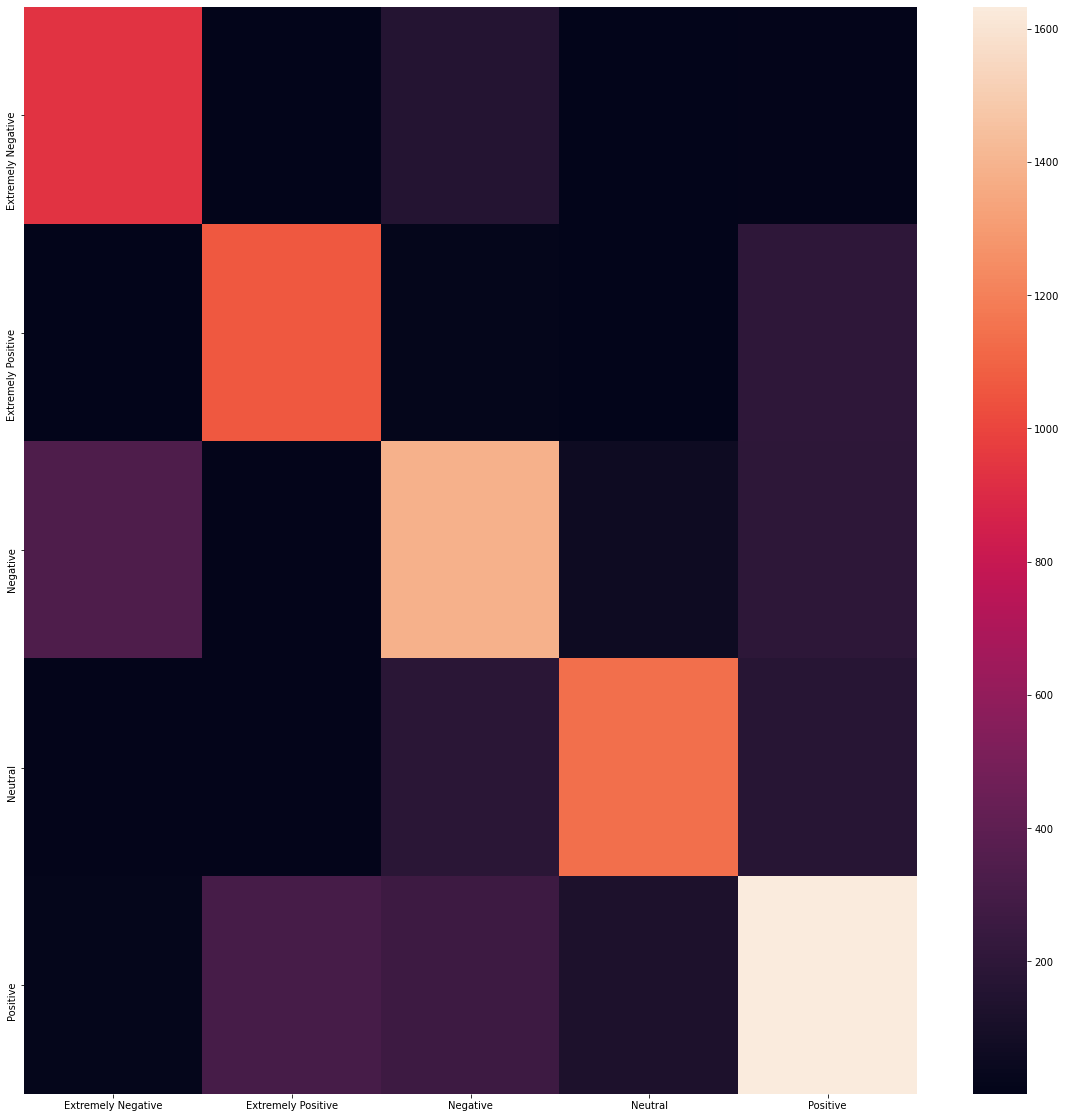

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
sns.heatmap(df)